# Introduction: Kickstarter Success Prediction Project
In this notebook, I'm going to look at the different features of kickstarter campaigns and how they correspond to the likelihood that a campaign will succeed. The dataset can be found here: https://data.world/rdowns26/kickstarter-campaigns/workspace/data-dictionary

In [67]:
# @hiden_cell
#pandas and numpy for data manipulation
import pandas as pd
import numpy as np

#visualization libraries for graphing
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 2)
%matplotlib inline

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Display up to the total number of columns of this dataframe
pd.set_option('display.max_columns', 67)

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

# Splitting data into training and testing
from sklearn.model_selection import train_test_split

In [79]:
df = pd.read_csv("kickstarter_data_full.csv", index_col=0);

C:\Users\riley\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (29,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [80]:
df.shape

(20632, 67)

The dataset starts out with 20,632 observations of 67 features.

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20632 entries, 0 to 20631
Data columns (total 67 columns):
id                             20632 non-null int64
photo                          20632 non-null object
name                           20632 non-null object
blurb                          20627 non-null object
goal                           20632 non-null float64
pledged                        20632 non-null float64
state                          20632 non-null object
slug                           20632 non-null object
disable_communication          20632 non-null bool
country                        20632 non-null object
currency                       20632 non-null object
currency_symbol                20632 non-null object
currency_trailing_code         20632 non-null bool
deadline                       20632 non-null object
state_changed_at               20632 non-null object
created_at                     20632 non-null object
launched_at                    20632 non-null 

# Data Cleaning
The majority of the dataset contains integer variables, some floats, and some objects. There is a chunk with only 60 observations (friends, is_starred, is_backing, and permissions). These look weird, so I'm going to look closer.

In [82]:
df['friends'].isnull().value_counts()

True     20572
False       60
Name: friends, dtype: int64

It looks like there are only 60 rows in which friends is not null, so I went ahead and looked at the other three variables and saw that that was the case. I decided to drop all four of those variables.

In [83]:
cols_to_drop = ['friends', 'is_starred', 'is_backing', 'permissions']

df.drop(labels=cols_to_drop, axis=1, inplace=True)

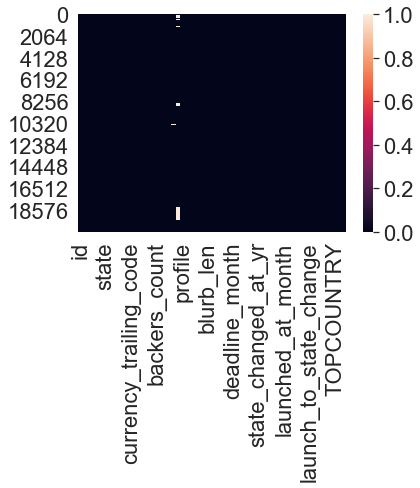

In [84]:
sns.heatmap(df.isnull()) #looking here we can see that 'is_backing' and 'profile' contain missing values, so we will need to look into those.

I can see that the only other column with missing values is the profile column. Looking at the first item of this we can learn a bit of what kind of data that involves and whether or not it is valuable.

In [85]:
df['profile'][0]

'{"background_image_opacity":0.8,"should_show_feature_image_section":true,"link_text_color":null,"state_changed_at":1425915885,"blurb":null,"background_color":null,"project_id":1546341,"name":null,"feature_image_attributes":{"image_urls":{"default":"https://ksr-ugc.imgix.net/assets/011/959/953/4e53aa51f82e9764b135307761da1cde_original.JPG?w=1552&h=873&fit=fill&bg=000000&v=1463719439&auto=format&q=92&s=70c684eaeb2b96fff3283fa72daeabee","baseball_card":"https://ksr-ugc.imgix.net/assets/011/959/953/4e53aa51f82e9764b135307761da1cde_original.JPG?w=1552&h=873&fit=fill&bg=000000&v=1463719439&auto=format&q=92&s=70c684eaeb2b96fff3283fa72daeabee"}},"link_url":null,"show_feature_image":false,"id":1546341,"state":"inactive","text_color":null,"link_text":null,"link_background_color":null}'

It looks like it is mostly metadata and some of the information is captured by other columns like state, blurb, and so on. The dataset is heavily featured in general so I'm going to drop this one too.

In [86]:
df.drop(labels='profile', axis=1, inplace=True)

I was going to look at the state variable but since that includes values like inactive and cancelled, it has too many levels. There's one better in this dataset: SuccessfulBool, 0=failed and 1=succeeded. We will use that for our dependent variable. Let's take a look at the distribution below.

In [87]:
#there are a lot of unnecessary features, I will give a short explanation comment inline for each
second_col_drop = ['id', #useful as a private key but we aren't joining tables, so it's uninformative
                   'photo', #I'm not going to go into image recognition in this project so I can't get any information from photo and there is no useful metadata,, just URLs
                   'state', #we already have SuccessfulBool, the cleaned version of state
                   'slug', #the legal characterization of the name column so it's redundant
                   'currency_symbol', #already have currency code (USD)
                   'currency_trailing_code', #honestly, I don't know what this is, but I think all I need is currency and the amount
                   'static_usd_rate', #I think this has to do with instances where the majority of backers pay non USD but there is some USD pledged (which is the next column). This project is scoped for USD so dropping both
                   'usd_pledged', #see above
                   'creator', #looked at this and while name could be captured among some other things, it's not important for the scope of my idea again
                   'location', #redundant. I already have the country and would like to go only within the US, it has 14,141 instances so it's a decent sized dataset even if just US, so no issues there. To do a visualization by state and city later on though, there are keys and values in here that would get that information.
                   'urls', #just URLs, not using them
                   'source_url', #similar reason
                   'name_len', #there is a cleaned version
                   'blurb_len', #same as above
                   'create_to_launch', #calculated but an object, there exists an int column of the same info for this and the following two
                   'launch_to_deadline', #same as above
                   'launch_to_state_change',#same as above
                   'USorGB', #probably for GDPR, don't need it for my purposes
                   'TOPCOUNTRY', #probably indicates top country, again not part of my project
                   'LaunchedTuesday', #probably someone else's analysis, I'll see what is interesting to me and take my chances
                   'DeadlineWeekend', #same as above
                   'deadline_month', 'deadline_day', 'deadline_yr', 'deadline_hr', #the following four sets of variables already have an associated timeseries object that concatenates them all together into one for each
                   'state_changed_at_month', 'state_changed_at_day', 'state_changed_at_yr', 'state_changed_at_hr',
                   'created_at_month', 'created_at_day', 'created_at_yr', 'created_at_hr',
                   'launched_at_month', 'launched_at_day', 'launched_at_yr', 'launched_at_hr']
                   
df.drop(labels=second_col_drop, axis=1, inplace=True)

In [88]:
df.shape

(20632, 25)

We reduced dimensionality from 67 to 25! Now we are getting close to thinking about doing exploratory data analysis.

In [89]:
df['disable_communication'] = df['disable_communication'] * 1 #converts type bool to 0 for false and 1 for true because in python a true bool is 1 and a false bool is 0.

In [90]:
df['staff_pick'] = df['staff_pick'] * 1 #doing the same for these two as well. If there were more than three I would do a for loop

df['spotlight'] = df['spotlight'] * 1

# Exploratory Data Analysis

Let's start this process by examing in the target feature: success of the campaigns.

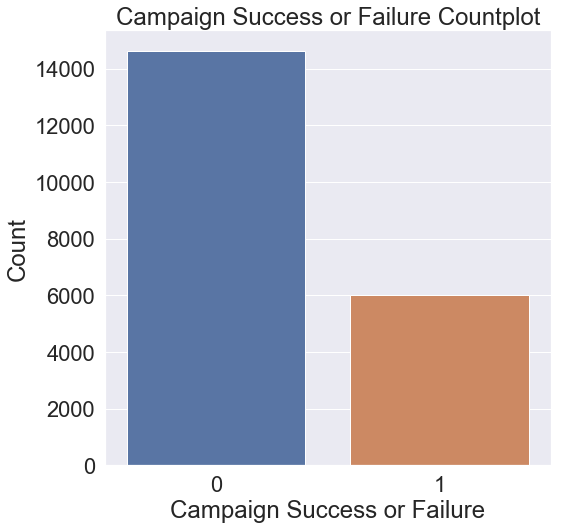

In [91]:
figsize(8, 8)
sns.countplot(df['SuccessfulBool']);
plt.xlabel('Campaign Success or Failure'); 
plt.ylabel('Count'); plt.title('Campaign Success or Failure Countplot');

#sns.countplot('SuccessfulBool', data=df)

In [92]:
print("Only " 
      + str(np.round(df['SuccessfulBool'].value_counts()[1] / len(df) * 100, decimals=2)) 
      + "% of campaigns were successful across the whole dataset.")

Only 29.17% of campaigns were successful across the whole dataset.


So we can see that there were more failed campaigns than successful campaigns. Sadly, this is expected and understandable.

## Outlier data

In [93]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
goal,20632.0,94104.965285,1.335511e+06,1.0,4000.0,14000.0,50000.00,1.000000e+08
pledged,20632.0,21392.675739,1.204973e+05,0.0,25.0,695.0,5954.25,6.225355e+06
disable_communication,20632.0,0.011148,1.049952e-01,0.0,0.0,0.0,0.00,1.000000e+00
staff_pick,20632.0,0.105903,3.077215e-01,0.0,0.0,0.0,0.00,1.000000e+00
backers_count,20632.0,183.675843,1.222013e+03,0.0,2.0,12.0,63.00,1.058570e+05
spotlight,20632.0,0.291683,4.545481e-01,0.0,0.0,0.0,1.00,1.000000e+00
name_len_clean,20627.0,5.292578,2.418168e+00,1.0,3.0,5.0,7.00,1.400000e+01
blurb_len_clean,20627.0,13.081204,3.283547e+00,1.0,11.0,13.0,15.00,3.000000e+01
create_to_launch_days,20632.0,49.577598,1.110946e+02,0.0,3.0,14.0,45.00,1.754000e+03
launch_to_deadline_days,20632.0,34.716896,1.187314e+01,1.0,30.0,30.0,40.00,9.100000e+01


It looks like the goal variable has a huge spread. I'll take a look at the tail of sorted values below.

In [94]:
df['goal'].sort_values().tail()

3487      40000000.0
11043     55000000.0
8678      60000000.0
4801     100000000.0
8696     100000000.0
Name: goal, dtype: float64

Looking at the goal value, we can see that the last two are 100 million dollars! These are some serious outliers!

In [95]:
df['pledged'].sort_values().tail()

8763     2708472.39
12829    2952508.59
12911    4961032.74
4363     5408916.95
8805     6225354.98
Name: pledged, dtype: float64

Understandably, the pledged amount is more reasonable because this represents real money that people decided to give. Simmer down there, project managers!

I will use the definition of extreme outlier, which is that the value is outside the bounds of the first and third quartile, or the interquartile range. Let's define that here and then plot the goal with just interquartile range included.

In [96]:
first_quartile = df['goal'].describe()['25%']

third_quartile = df['goal'].describe()['75%']

iqr = third_quartile - first_quartile

df_goal_iqr = df[(df['goal'] > first_quartile) & (df['goal'] < third_quartile)]

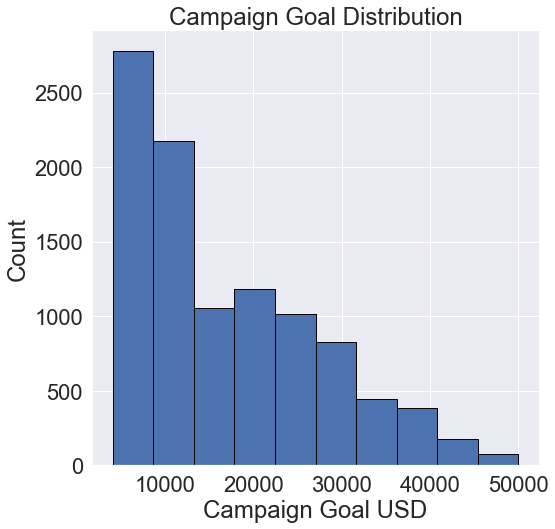

In [97]:
# Histogram Plot of Site EUI
figsize(8, 8)
plt.hist(df_goal_iqr['goal'], edgecolor = 'black');
plt.xlabel('Campaign Goal USD'); 
plt.ylabel('Count'); plt.title('Campaign Goal Distribution');

### More outliers

A box and whisker plot is a good way to look at different variables and their spread and see if there are any more outliers to deal with using the previously used methods. First lets re-examine the spread of the variables using .describe().transpose() to see which ones have high spread (for example a min of 0 and a max of 2,344,000 with a standard deviation of 67,000!).

In [99]:
df_goal_iqr.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
goal,10107.0,16841.510237,10887.732017,4059.0,8000.0,15000.0,25000.0,49999.00
pledged,10107.0,14891.312073,67578.044235,0.0,28.0,840.0,8489.0,2344134.67
disable_communication,10107.0,0.011477,0.106520,0.0,0.0,0.0,0.0,1.00
staff_pick,10107.0,0.109330,0.312068,0.0,0.0,0.0,0.0,1.00
backers_count,10107.0,173.063125,907.532746,0.0,2.0,13.0,82.0,36781.00
spotlight,10107.0,0.266053,0.441914,0.0,0.0,0.0,1.0,1.00
name_len_clean,10105.0,5.366452,2.431118,1.0,3.0,6.0,7.0,14.00
blurb_len_clean,10105.0,13.073726,3.285475,1.0,11.0,13.0,15.0,30.00
create_to_launch_days,10107.0,53.305036,113.766666,0.0,4.0,16.0,50.0,1692.00
launch_to_deadline_days,10107.0,34.896309,11.219802,1.0,30.0,30.0,40.0,91.00


I can see I definitely want to do something to tame backers_count, and create_to_launch_days, and pledged due to the high spread. Let's confirm with a box and whisker for each.

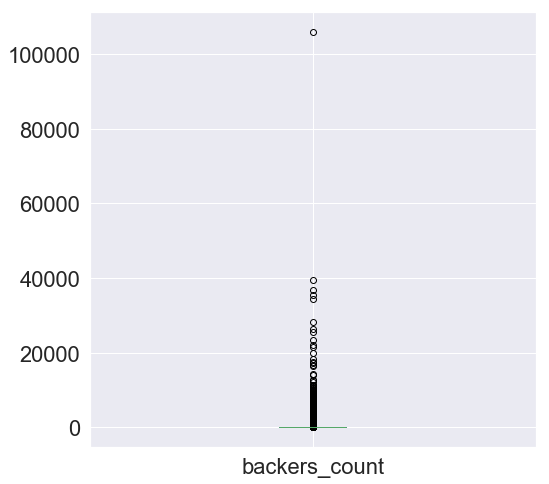

In [101]:
df.boxplot(['backers_count'])

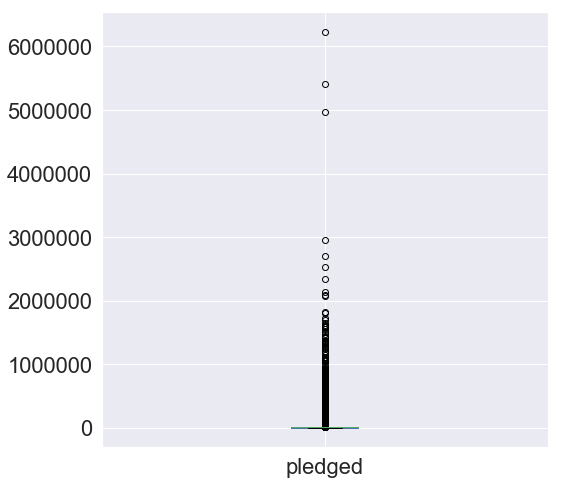

In [102]:
df.boxplot(['pledged'])

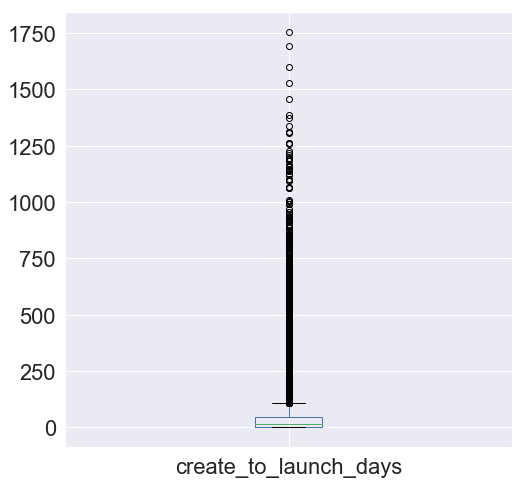

In [103]:
df.boxplot(['create_to_launch_days'])

Yeah, let's definitely trim all three of those and create a new IQR dataframe with these truncated values.

In [104]:
df_iqr_trimmed = df_goal_iqr

first_quartile = df['create_to_launch_days'].describe()['25%']
third_quartile = df['create_to_launch_days'].describe()['75%']

iqr = third_quartile - first_quartile

df_iqr_trimmed = df[(df['create_to_launch_days'] > first_quartile) & (df['create_to_launch_days'] < third_quartile)]

#-------------------------------------------------------------------

first_quartile = df['pledged'].describe()['25%']
third_quartile = df['pledged'].describe()['75%']

iqr = third_quartile - first_quartile

df_iqr_trimmed = df[(df['pledged'] > first_quartile) & (df['pledged'] < third_quartile)]

#-------------------------------------------------------------------

first_quartile = df['backers_count'].describe()['25%']
third_quartile = df['backers_count'].describe()['75%']

iqr = third_quartile - first_quartile

df_iqr_trimmed = df[(df['backers_count'] > first_quartile) & (df['backers_count'] < third_quartile)]

In [105]:
len(df_iqr_trimmed)

9308

This reduction resulted in a dataframe where there are 9308 instances, with only the IQR for the variables in question remaining.

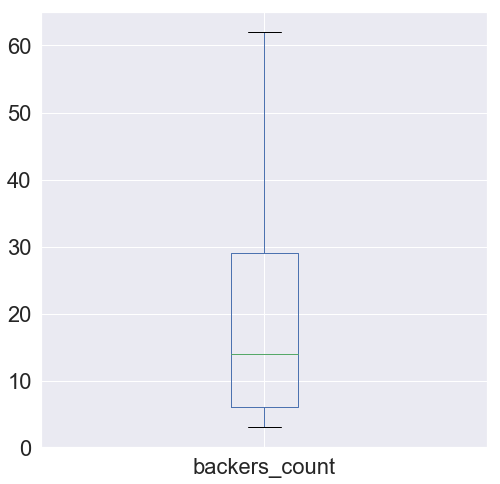

In [106]:
df_iqr_trimmed.boxplot(['backers_count']) #for example, this looks a bit more reasonable.

### Correlations

Next up let's look at the correlations between each variable against SuccessfulBool, which remember, is a binary value where 0=failed and 1=succeeded.

In [107]:
df_iqr_trimmed.corr()['SuccessfulBool'].sort_values()

launch_to_deadline_days       -0.184938
create_to_launch_days         -0.085983
disable_communication         -0.053091
launch_to_state_change_days   -0.047071
goal                          -0.033484
name_len_clean                -0.027807
blurb_len_clean                0.058825
staff_pick                     0.109232
pledged                        0.133948
backers_count                  0.404936
spotlight                      1.000000
SuccessfulBool                 1.000000
Name: SuccessfulBool, dtype: float64

Looking at the correlations above we can see that nothing is too strongly correlated except spotlight, backers_count, pledged, and staff_pick. But really the only significant ones are backers_count and spotlight. It's crazy that spotlight has a correlation of 1. I'm going to look at that one real quick.

In [108]:
len(df_iqr_trimmed[df_iqr_trimmed['spotlight'] == 1])

2200

In [110]:
len(df_iqr_trimmed[df_iqr_trimmed['SuccessfulBool'] == 1])

2200

As we can see, there are exactly 2200 that are in the spotlight and were successful. And taken together with the spotlight variable's correlation to SuccessfulBool, we can conclude that all spotlighted campaigns were successful, at least in this dataset, taking into account the fact that it is reduced to IQR values only.

I'm going to pool together these strongly correlated features for feature selection later to see if restricting the model's training on just these features will improve, detract from, or keep performance neutral.

In [111]:
reduced_x_features = df_iqr_trimmed[['launch_to_deadline_days', 'staff_pick', 'pledged', 'backers_count', 'spotlight', 'goal']]
reduced_y = df_iqr_trimmed['SuccessfulBool']

Because of the original format of the variables, we need to take the log and sqrt transformations of them and check correlation with those as well to account for non-linear relationships.

In [112]:
# Select the numeric columns
numeric_subset = df_iqr_trimmed.select_dtypes('number')

# Create columns with square root and log of numeric columns
for col in numeric_subset.columns:
    # Skip the Energy Star Score column
    if col == 'SuccessfulBool':
        next
    else:
        numeric_subset['sqrt_' + col] = np.sqrt(numeric_subset[col])
        numeric_subset['log_' + col] = np.log(numeric_subset[col])

# Select the categorical columns
categorical_subset = df_iqr_trimmed['category']

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

# Drop buildings without an energy star score
features = features.dropna(subset = ['SuccessfulBool'])

# Find correlations with the score 
correlations = features.corr()['SuccessfulBool'].dropna().sort_values()
correlations.head()

C:\Users\riley\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
C:\Users\riley\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


log_goal                       -0.554957
sqrt_goal                      -0.272015
log_launch_to_deadline_days    -0.219717
sqrt_launch_to_deadline_days   -0.205036
launch_to_deadline_days        -0.184938
Name: SuccessfulBool, dtype: float64

So we saw in the previous step that goal got a boost in correlation what you take its log, so I will add log_goal into the reduced_x_features dataframe. We also saw log_pledged show a significant boost as well, so that will be included.

In [115]:
reduced_x_features['log_goal'] = features['log_goal']
reduced_x_features['log_pledged'] = features['log_pledged']
reduced_x_features.drop('pledged', axis=1, inplace=True)

KeyError: "['pledged'] not found in axis"

# Feature Engineering and Selection

I selected variables based on their correlations with the target variable, either positive or negative. This is feature selection, or rather deselection, because there were many that I was ignoring and not selecting. Feature engineering is the process of creating new features from existing ones in a sense, so when I transformed goal and pledged to log_goal and log_pledged, I found that these had a stronger correlation than their original forms, so these new features were added to reduced_x_features.

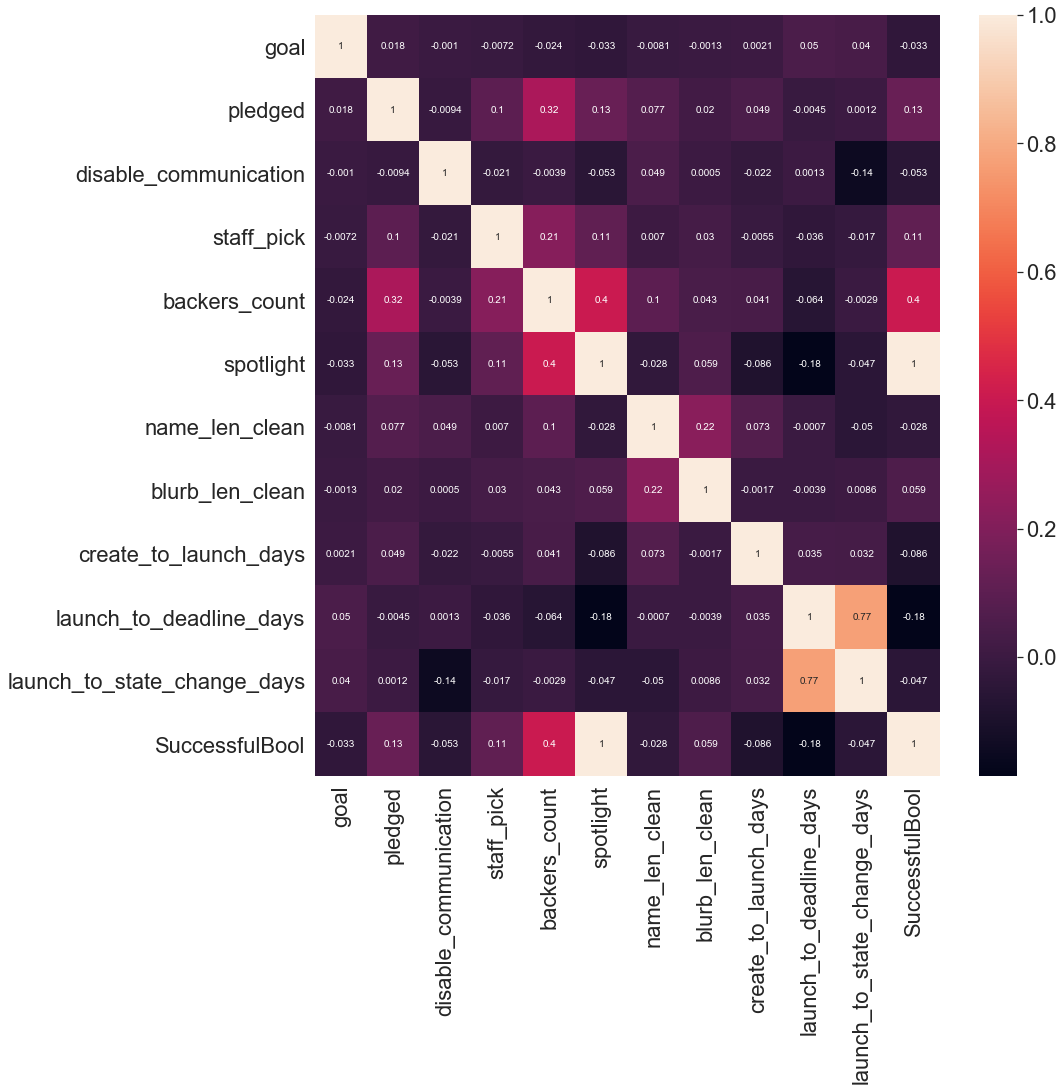

In [116]:
figsize(14,14)
sns.heatmap(df_iqr_trimmed.corr(), annot=True)

# Modeling

In [117]:
from sklearn.model_selection import train_test_split

# Split into 70% training and 30% testing set
X, X_test, y, y_test = train_test_split(reduced_x_features, reduced_y, test_size = 0.20, random_state = 101)

print(X.shape)
print(X_test.shape)
print(y.shape)
print(y_test.shape)

(7446, 7)
(1862, 7)
(7446,)
(1862,)


In [118]:
# Imputing missing values and scaling values
from sklearn.preprocessing import MinMaxScaler

# Machine Learning Models
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

If I use scalers, the values that are non-binary come to be mapped relative to their original values in a range between 0 and 1. Since this is a classification problem, this boosts the correlation between variables against the target variable too much and leads to perfect performance across all machine learning algorithms. Because of this I will not scale.

In [119]:
from sklearn.metrics import classification_report, confusion_matrix

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X, y)
    
    # Make predictions and evalute
    predictions = model.predict(X_test)
    
    # Return the performance metric
    return print(classification_report(y_test, predictions), '\n', confusion_matrix(y_test, predictions))

In [120]:
lr = LogisticRegression()

fit_and_evaluate(lr)

             precision    recall  f1-score   support

          0       0.93      0.94      0.94      1411
          1       0.82      0.77      0.79       451

avg / total       0.90      0.90      0.90      1862
 
 [[1333   78]
 [ 102  349]]


In [121]:
svm = SVC(C = 1000, gamma = 0.1)

fit_and_evaluate(svm)

             precision    recall  f1-score   support

          0       0.87      0.97      0.92      1411
          1       0.87      0.56      0.68       451

avg / total       0.87      0.87      0.86      1862
 
 [[1374   37]
 [ 198  253]]


In [122]:
random_forest = RandomForestClassifier(random_state=101)

fit_and_evaluate(random_forest)

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1411
          1       1.00      1.00      1.00       451

avg / total       1.00      1.00      1.00      1862
 
 [[1411    0]
 [   0  451]]


In [124]:
knn = KNeighborsClassifier(n_neighbors=5)

fit_and_evaluate(knn)

             precision    recall  f1-score   support

          0       0.93      0.94      0.94      1411
          1       0.82      0.79      0.81       451

avg / total       0.91      0.91      0.91      1862
 
 [[1332   79]
 [  93  358]]


In [176]:
gradient_boosted = GradientBoostingClassifier(random_state=60)

fit_and_evaluate(gradient_boosted)

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1411
          1       1.00      1.00      1.00       451

avg / total       1.00      1.00      1.00      1862
 
 [[1411    0]
 [   0  451]]


This one has perfect performance so we will use that to predict a new campaign:

In [190]:
reduced_x_features

#log of 14000 is 9.6, which means the goal is 1000 and the pledged is 14000, and it still only has a 20% of succeeding even though it already has by definition. This algo is broke.
gradient_boosted.predict_proba([[45, 0, 6, 1, 15000, 9.62, 6.91]])

array([[5.44896131e-04, 9.99455104e-01]])

A campaign with 45 days until the deadline, that was not staff picked, backed by 6 backers, is in the spotlight, has a goal of 15000 USD, which is a log_goal of 9.62, and a log_pledged of 6.91 (equal to 1000 USD) has a 99.9% chance of succeeding!

# Interpretation

In [185]:
importances = gradient_boosted.feature_importances_

feature_list = list(X.columns)

feature_results = pd.DataFrame({'feature': feature_list,
                               'importance': importances})

feature_results

,feature,importance
0,launch_to_deadline_days,0.00
1,staff_pick,0.00
2,backers_count,0.00
3,spotlight,0.72
4,goal,0.00
5,log_goal,0.00
6,log_pledged,0.00


According to our gradient boosting classifier algorithm's calculations, the most important feature in determining the outcome of a Kickstarter campaign is whether or not it is in the spotlight. That makes sense!

# Conclusions

With this dataset, it is possible to predict the success or failure of a kickstarter campaign with just 7 variables describing it, and with the gradient_boosted.predict_proba() method, we can know the probability of either failure or success, given a new input of unseen features.